In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
import missingno as mn

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import NotFittedError

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
# machine learning library
from sklearn.linear_model import LinearRegression

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import(recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc)

#SHAP explainer
import shap
# Ensure your pipeline is defined
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
#LIME
import lime
import lime.lime_tabular

#widgets and dispaly
import ipywidgets as widgets
from IPython.display import display

#utilities
import pickle
import os
from tqdm import tqdm

c:\Users\ADMIN\anaconda3\envs\ds-gg\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Business goal
- Determine prices of properties based on the features

### Loading data

In [2]:
file_path = 'data/housing.csv'

df = pd.read_csv(file_path)

df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.20,47.34
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.36,47.51
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.16,47.44
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.37,47.57
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.18,47.73


# 1. EDA


In [3]:
num_record = df.shape[0]
num_features = df.shape[1]
data_types = df.dtypes

print(f'Number of records: {num_record}')
print(f'\nNumber of features {num_features}')
print(f'\nData types: \n{data_types}')

Number of records: 4944

Number of features 22

Data types: 
SalePrice               int64
SqFt1stFloor            int64
SqFtHalfFloor           int64
SqFt2ndFloor            int64
SqFtUpperFloor          int64
SqFtTotLiving           int64
SqFtTotBasement         int64
SqFtFinBasement         int64
SqFtGarageBasement      int64
SqFtGarageAttached      int64
DaylightBasement        int64
SqFtOpenPorch           int64
SqFtEnclosedPorch       int64
SqFtDeck                int64
BrickStone              int64
Bedrooms                int64
BathHalfCount           int64
Bath3qtrCount           int64
BathFullCount           int64
YrBuilt                 int64
Longitude             float64
Latitude              float64
dtype: object


<Axes: >

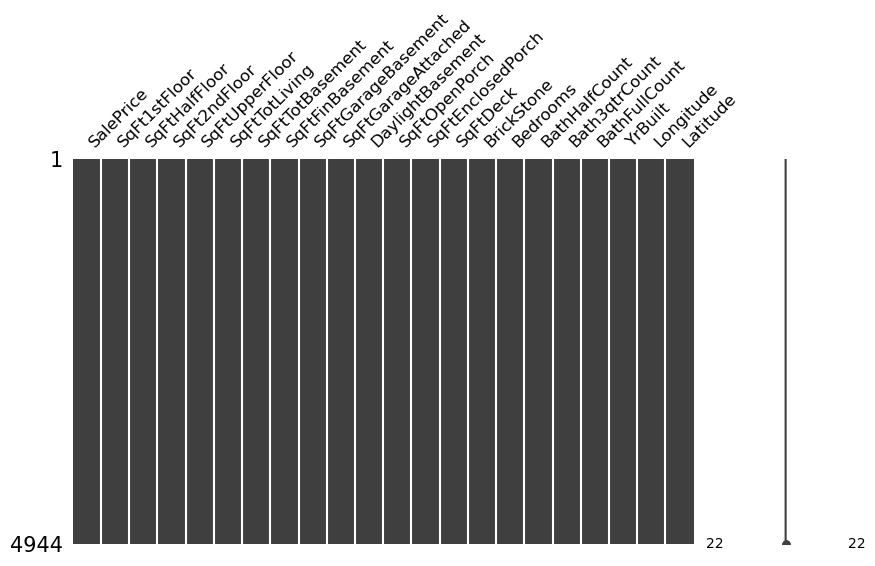

In [4]:
#visualize missing values
mn.matrix(df, figsize=(10,5), width_ratios=(5,1), fontsize=12)

In [5]:
duplicated_rows = df.duplicated().sum()
missing_values = df.isna().sum()

print(f'Number of duplicated rows: {duplicated_rows}')
print(f'\nNumber of missing values: \n{missing_values}')

Number of duplicated rows: 29

Number of missing values: 
SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64


In [6]:
statistics = df.describe()
print(f'\nStatistics: {statistics}')


Statistics:        SalePrice  SqFt1stFloor  SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  \
count    4944.00       4944.00        4944.00       4944.00         4944.00   
mean   664349.73       1175.50          51.76        349.31           26.99   
std    297808.04        446.40         174.46        544.63          115.33   
min     60000.00        260.00           0.00          0.00            0.00   
25%    450000.00        880.00           0.00          0.00            0.00   
50%    630550.00       1170.00           0.00          0.00            0.00   
75%    788612.50       1450.00           0.00        580.00            0.00   
max   1998000.00       3600.00        2000.00       3010.00         1220.00   

       SqFtTotLiving  SqFtTotBasement  SqFtFinBasement  SqFtGarageBasement  \
count        4944.00          4944.00          4944.00             4944.00   
mean         1935.21           595.07           334.27              102.42   
std           764.89           567.18    

In [7]:
def check_column_values(df):
    for column in df.columns:
        print(f'Unique Values in {column} column:')
        print(df[column].unique())
        print('\n')

check_column_values(df)

Unique Values in SalePrice column:
[ 400000  474250  667950 ...  934939  442000 1214950]


Unique Values in SqFt1stFloor column:
[1590 1390 1010  660 2310 1330 1420 1020 1120  770 1060 1730 1450  850
 1280 1110 1090 1820  980 1380 1130  500  360  430  730 1320 1710 1025
 1660 1500 1860  840 1650  960 1180 1230 1480 1430  920 2380  700  950
 1410 1140  900 1490  790  420 1560 1740 1300 1400 1053 1220 1100 1150
  690 1561 1250  810 1270 1210  880 1310  640 1030 1190  600 1050 1200
 1800  610  410  511  440 1840  800  830  890 1370  820 1260 1340 1711
  670  520 1640 1470 1080  984 1160  550 1780 2210  940 1040  990 1940
  910 2330 1920  570 1880 1670 1360 1610 2000 1690  390 1240 1350  710
 1680  860 1000 1193 1620 1580  590  780 1988  330 2790  540  400 1290
  580 1700 2010 1440 1540 1570 2110  480 2390  460 2580 2420 1170 2710
  930 1151 1070 1760 1720 1304 2260 2190 1930 2490 1179 1830  650 1890
  260 2360 1530  380  680  470  750 3030  870 1810  970 2120  620 1550
 1970  441 1900 151

In [8]:
num_cols = df.select_dtypes(include='number')

corr = num_cols.corr()
corr.style.background_gradient(cmap='coolwarm').format('{:.2f}')

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
SalePrice,1.00,0.18,0.10,0.37,0.07,0.51,0.19,0.20,0.02,0.09,0.09,0.21,0.00,0.20,0.08,0.26,0.17,0.19,0.29,0.13,0.07,0.41
SqFt1stFloor,0.18,1.00,-0.01,-0.08,-0.32,0.58,0.21,0.19,0.09,0.39,-0.03,0.19,-0.06,-0.05,0.08,0.45,0.02,0.09,0.19,-0.25,0.40,-0.12
SqFtHalfFloor,0.10,-0.01,1.00,-0.14,-0.04,0.07,0.06,-0.07,-0.08,-0.09,-0.15,0.03,0.03,-0.07,0.08,0.09,-0.01,-0.09,-0.03,-0.30,-0.11,0.07
SqFt2ndFloor,0.37,-0.08,-0.14,1.00,0.11,0.54,-0.30,-0.20,-0.13,0.36,-0.15,0.39,-0.00,-0.00,-0.11,0.30,0.29,0.08,0.50,0.59,0.18,-0.01
SqFtUpperFloor,0.07,-0.32,-0.04,0.11,1.00,-0.06,-0.20,-0.16,-0.06,-0.13,-0.13,-0.06,0.06,0.17,-0.04,-0.13,0.04,0.05,0.01,0.32,-0.17,0.09
SqFtTotLiving,0.51,0.58,0.07,0.54,-0.06,1.00,0.32,0.49,0.07,0.39,0.14,0.37,-0.03,0.12,0.04,0.66,0.25,0.28,0.53,0.24,0.32,-0.02
SqFtTotBasement,0.19,0.21,0.06,-0.30,-0.20,0.32,1.00,0.78,0.49,-0.28,0.55,-0.05,-0.01,0.17,0.17,0.24,-0.00,0.22,0.03,-0.24,-0.07,0.14
SqFtFinBasement,0.20,0.19,-0.07,-0.20,-0.16,0.49,0.78,1.00,0.25,-0.09,0.58,-0.03,-0.01,0.25,0.11,0.32,0.04,0.33,0.12,-0.02,0.03,0.06
SqFtGarageBasement,0.02,0.09,-0.08,-0.13,-0.06,0.07,0.49,0.25,1.00,-0.32,0.38,-0.09,-0.03,0.07,0.04,0.03,0.10,0.19,0.00,0.08,0.03,0.09
SqFtGarageAttached,0.09,0.39,-0.09,0.36,-0.13,0.39,-0.28,-0.09,-0.32,1.00,-0.19,0.28,-0.07,-0.09,-0.06,0.29,0.11,0.03,0.26,0.19,0.44,-0.22


In [9]:
df.columns = [col.strip() for col in df.columns]

# check updated column names
print(df.columns)

# check updated column names
df = df.drop_duplicates()

# check for duplicates
print(f'\nnumber of duplicate rows: {df.duplicated().sum()}')

Index(['SalePrice', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BrickStone',
       'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
       'YrBuilt', 'Longitude', 'Latitude'],
      dtype='object')

number of duplicate rows: 0


# 2. Data Visualization

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'SqFt1stFloor'}>,
        <Axes: title={'center': 'SqFtHalfFloor'}>,
        <Axes: title={'center': 'SqFt2ndFloor'}>,
        <Axes: title={'center': 'SqFtUpperFloor'}>],
       [<Axes: title={'center': 'SqFtTotLiving'}>,
        <Axes: title={'center': 'SqFtTotBasement'}>,
        <Axes: title={'center': 'SqFtFinBasement'}>,
        <Axes: title={'center': 'SqFtGarageBasement'}>,
        <Axes: title={'center': 'SqFtGarageAttached'}>],
       [<Axes: title={'center': 'DaylightBasement'}>,
        <Axes: title={'center': 'SqFtOpenPorch'}>,
        <Axes: title={'center': 'SqFtEnclosedPorch'}>,
        <Axes: title={'center': 'SqFtDeck'}>,
        <Axes: title={'center': 'BrickStone'}>],
       [<Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'BathHalfCount'}>,
        <Axes: title={'center': 'Bath3qtrCount'}>,
        <Axes: title={'center': 'BathFullCount'}>,
        <Axes: title={'ce

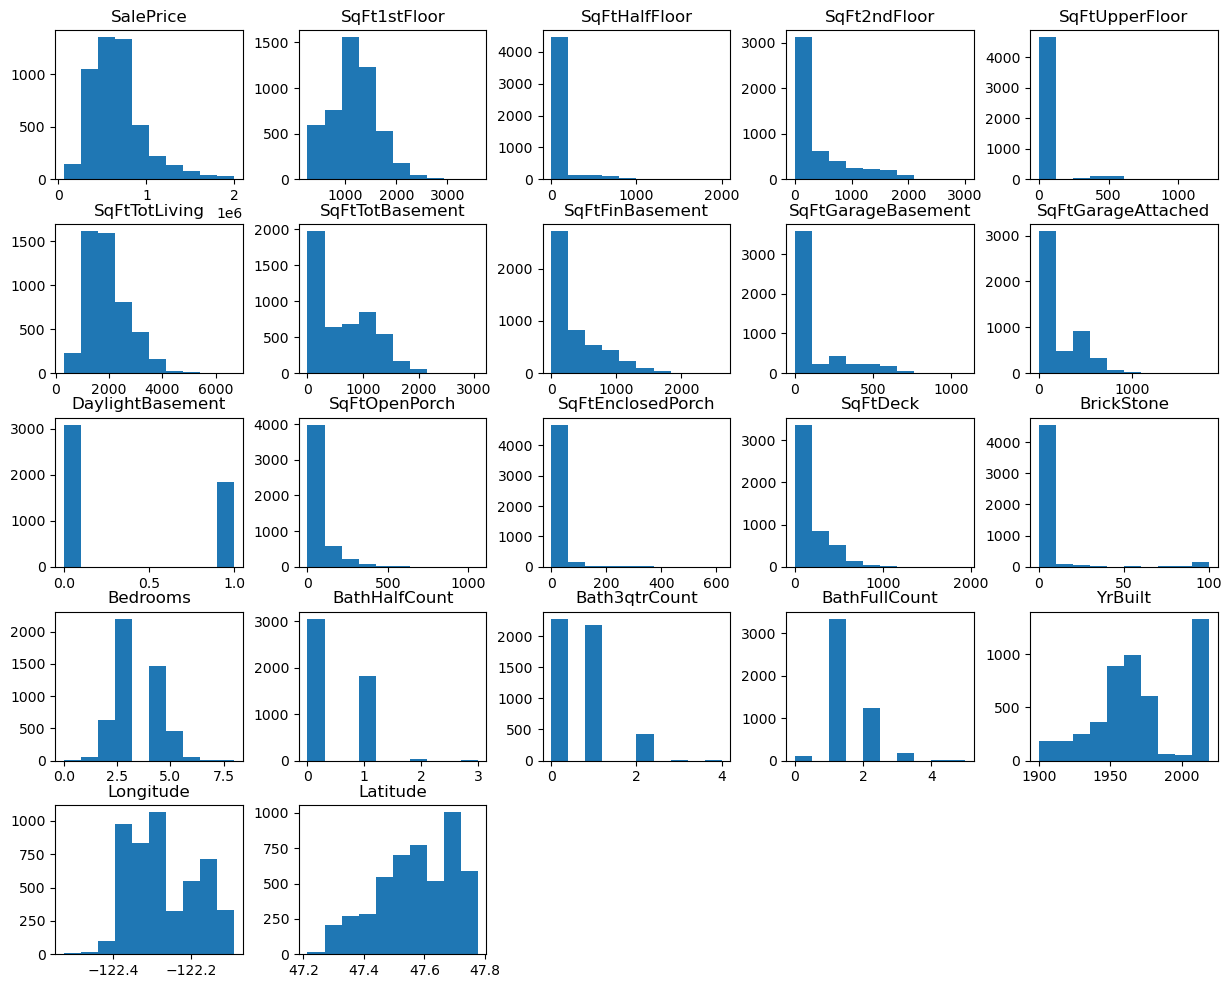

In [10]:
#Data Overview
df.hist(figsize=(15,12), bins=10, grid=False)

In [11]:
df.columns

Index(['SalePrice', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BrickStone',
       'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
       'YrBuilt', 'Longitude', 'Latitude'],
      dtype='object')

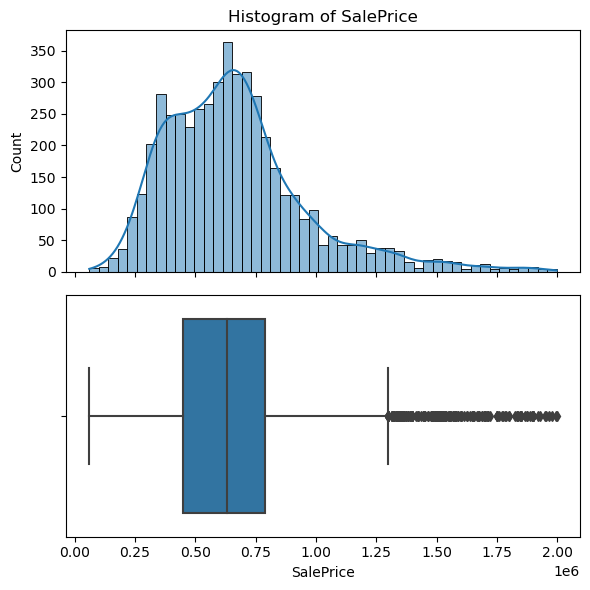

In [12]:
feature = 'SalePrice'

fig, axes = plt.subplots(nrows=2, figsize=(6,6), sharex=True)
sn.histplot(df[feature], bins='auto', kde=True, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title(f'Histogram of {feature}')

sn.boxplot(data=df, x=feature, ax=axes[1])
#remove grids
axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

### Observations
- The distribution of sale prices is right-skewed, meaning that most of the sale prices are concentrated on the lower end, with a long tail extending to the right.
- There is a peak around $500,000, indicating that this price range has the highest frequency of sales.
- The highest frequency of sale prices falls between $400,000 and $600,000, indicating that most houses are sold within this range.

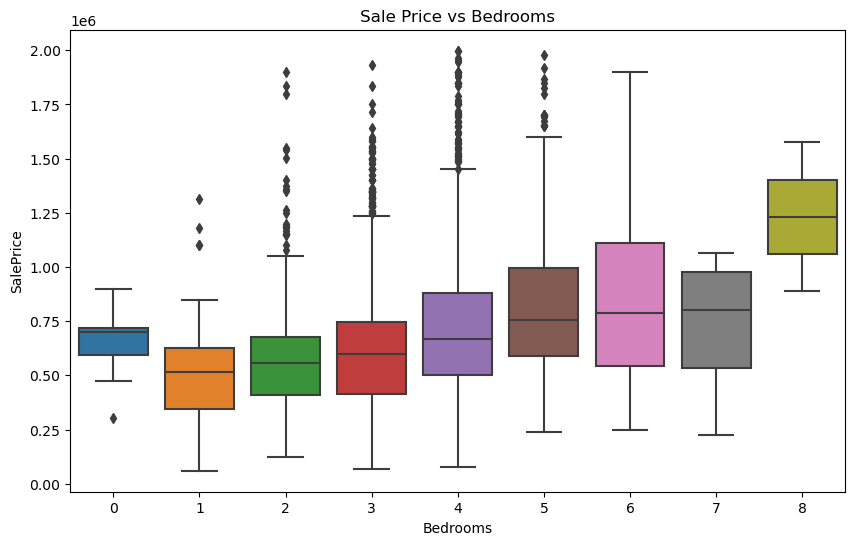

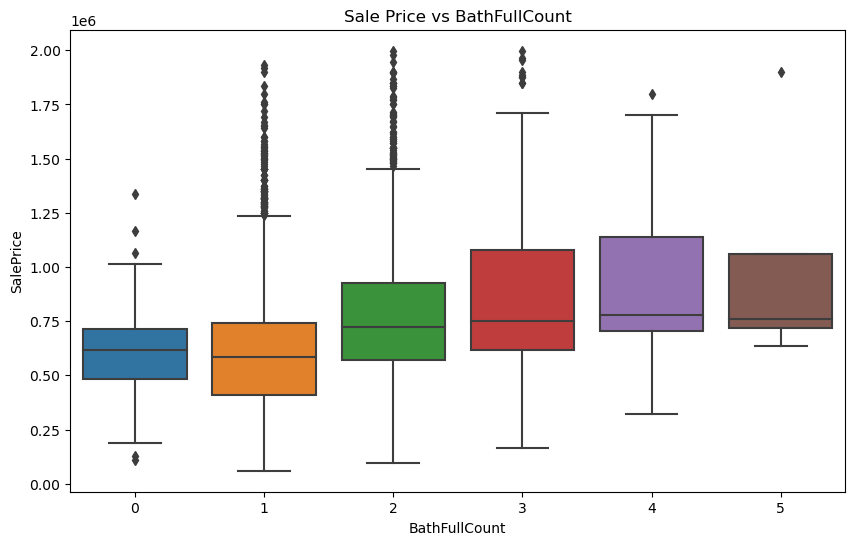

In [13]:
categorical_features = ['Bedrooms', 'BathFullCount']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sn.boxplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'Sale Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

### Observations
*Sale Price vs Bedrooms*
- The highest median sale prices are seen in houses with 8 bedrooms, while the median prices for 5 and 6 bedrooms also tend to be higher.
- Houses with 4 bedrooms show a considerable number of outliers above the upper whisker, indicating some properties are much more expensive than others within this category.

*Sale Price vs Bathrooms*
- As the number of full bathrooms increases from 0 to 3, the sale prices increase notably.
- Houses with 5 full bathrooms have a high median price but a narrow range, suggesting they might be luxury properties with consistent pricing.

# Machine Learning


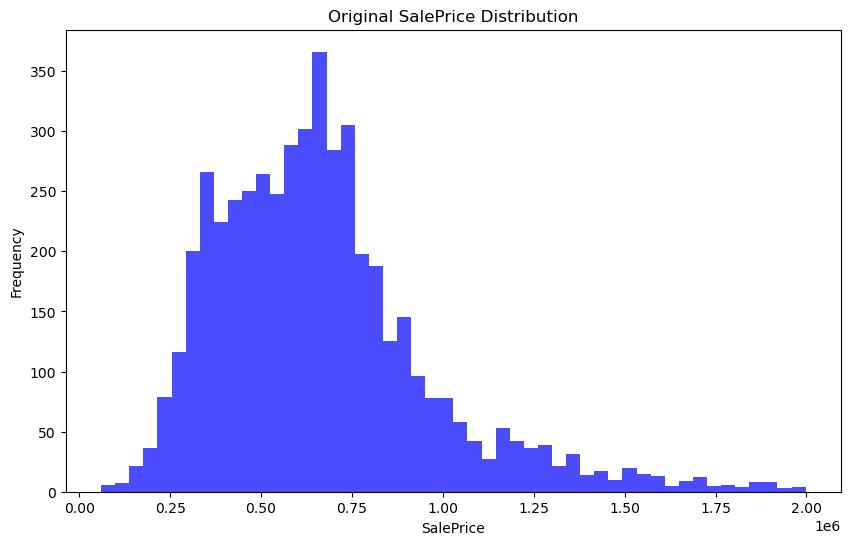

In [14]:
# Plot the original distribution of SalePrice
plt.figure(figsize=(10, 6))
plt.hist(df['SalePrice'], bins=50, color='blue', alpha=0.7)
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Split datab
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
#Prepare the data by selecting all numberic and object columns
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

#instantiate the transformers 
scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown='ignore')

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

#create pipelines
num_pipe = Pipeline([
    ('imputer', knn_imputer),
    ('scaler', scaler)
])

cat_pipe = Pipeline([
    ('encoder', ohe)
])

num_tuple = (num_pipe, num_cols)
cat_tuple = (cat_pipe, cat_cols)

#create ColumnTransformer
preprocessor = ColumnTransformer([
    ('numeric', num_pipe, num_cols),
    ('categorical', cat_pipe, cat_cols)
],remainder='drop')


In [45]:
# machine learning
# import libraries
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # define a function that takes true and predicted values as arguments
# and prints all 4 metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R²: {r2:.2f}')

In [53]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=100, random_state=42)

etr_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', etr),
    ])

#train the model
etr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002367856F6A0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002367856D5D0>)])),
                ('regressor', ExtraTreesRegressor(random_state=42))])

In [54]:
print('Extra Trees Regression Model')
print('Train Evaluation')
evaluate_model(y_train, etr_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, etr_pipe.predict(X_test))
print("\n")

Extra Trees Regression Model
Train Evaluation
MAE: 359.36
MSE: 12648449.94
RMSE: 3556.47
R²: 1.00

Test Evaluation
MAE: 106756.46
MSE: 29290574346.58
RMSE: 171144.89
R²: 0.69




In [59]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb),
    ])

#train the model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002367856F6A0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transform...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [67]:
print('XGBRegressor Model')
print('Train Evaluation')
evaluate_model(y_train, xgb_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, xgb_pipe.predict(X_test))
print("\n")

XGBRegressor Model
Train Evaluation
MAE: 30270.11
MSE: 1804531877.48
RMSE: 42479.78
R²: 0.98

Test Evaluation
MAE: 107673.04
MSE: 28506160583.75
RMSE: 168837.68
R²: 0.70




In [64]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()

en_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', en),
    ])

#train the model
en_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002367856F6A0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002367856D5D0>)])),
                ('regressor', ElasticNet())])

In [66]:
print('Elastic Net Regression Model')
print('Train Evaluation')
evaluate_model(y_train, xgb_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, xgb_pipe.predict(X_test))
print("\n")

Elastic Net Regression Model
Train Evaluation
MAE: 30270.11
MSE: 1804531877.48
RMSE: 42479.78
R²: 0.98

Test Evaluation
MAE: 107673.04
MSE: 28506160583.75
RMSE: 168837.68
R²: 0.70




### Hyperparameter Tuning

In [79]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


In [85]:
# Define models for tuning
models = {
    'ExtraTree': ExtraTreesRegressor(),
    'XGBoost': XGBRegressor(),
    'ElasticNet': ElasticNet()
}

# Define the parameter grid
param_grid = {
    'ExtraTree': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    
    'XGBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    },
    
    'ElasticNet': {
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    }
}

In [86]:
# Create a loop function to train and evaluate models
metrics_list = []
best_models = {}

def train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor):
    for model_name, model in tqdm(models.items(), desc='Training Models'):
        model_pipe = Pipeline(steps=[('regressor', model)])
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_pipe,
            param_grid=param_grid[model_name],
            cv=5,
            n_jobs=-1,
            scoring='r2')
        
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Predictions
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)
        
        # Evaluate classification models
        train_mse, train_rmse, train_mae, train_r2 = evaluate_regression(y_train, train_pred)
        test_mse, test_rmse, test_mae, test_r2 = evaluate_regression(y_test, test_pred)
        
        # Save metrics
        row = {
            'Model Used': model_name,
            'Training MSE': train_mse,
            'Training RMSE': train_rmse,
            'Training MAE': train_mae,
            'Training R²': train_r2,
            'Testing MSE': test_mse,
            'Testing RMSE': test_rmse,
            'Testing MAE': test_mae,
            'Testing R²': test_r2,
            'Best Params': grid_search.best_params_
        }
        metrics_list.append(row)

    # Convert the metrics into a Dataframe
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df, best_models

In [87]:
# Train and evaluate the tuned models
metrics_df, best_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor)
metrics_df

Training Models: 100%|██████████| 3/3 [01:05<00:00, 21.78s/it]


,Model Used,Training MSE,Training RMSE,Training MAE,Training R²,Testing MSE,Testing RMSE,Testing MAE,Testing R²,Best Params
0,ExtraTree,12690510.74,3562.37,366.05,1.00,29124025378.62,170657.63,106284.98,0.70,"{'regressor__max_depth': None, 'regressor__min..."
1,XGBoost,3877597083.69,62270.35,44377.06,0.96,25704186736.71,160325.25,102034.53,0.73,"{'regressor__learning_rate': 0.1, 'regressor__..."
2,ElasticNet,44783119592.18,211620.22,152660.77,0.49,52719121633.85,229606.45,161566.15,0.45,"{'regressor__alpha': 0.1, 'regressor__l1_ratio..."


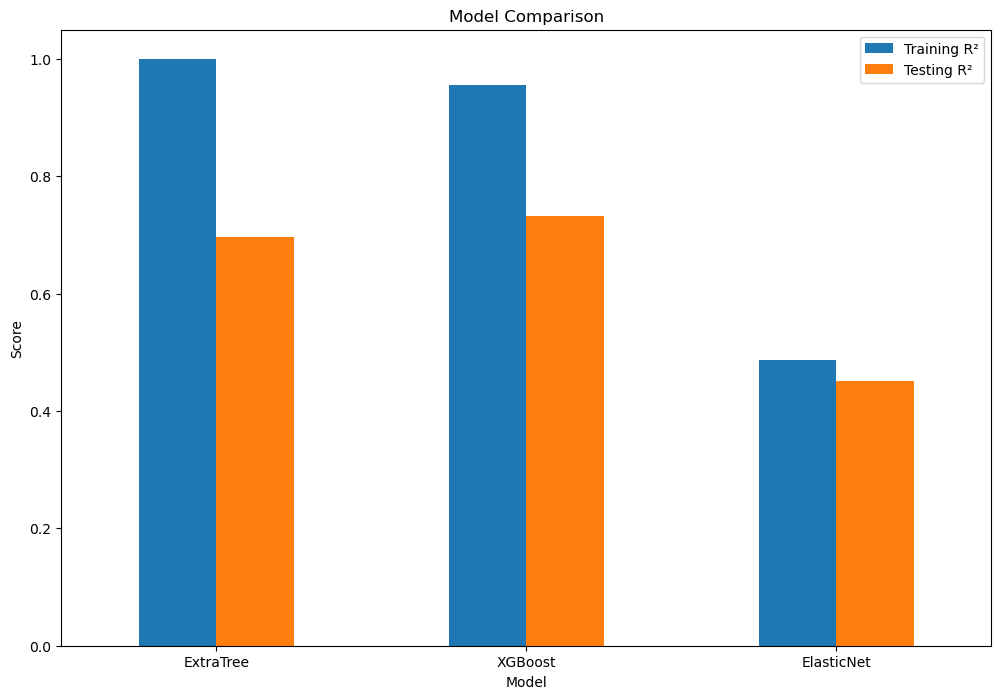

In [90]:
#create a function to displat the evaluation results
def display_evaluation_results(metrics_df):
    metrics_df.set_index('Model Used')[['Training R²', 'Testing R²']].plot(kind='bar', figsize=(12,8))

    plt.title('Model Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='best')
    plt.show()

display_evaluation_results(metrics_df)

Learning CUrve for ExtraTree
Learning CUrve for XGBoost
Learning CUrve for ElasticNet


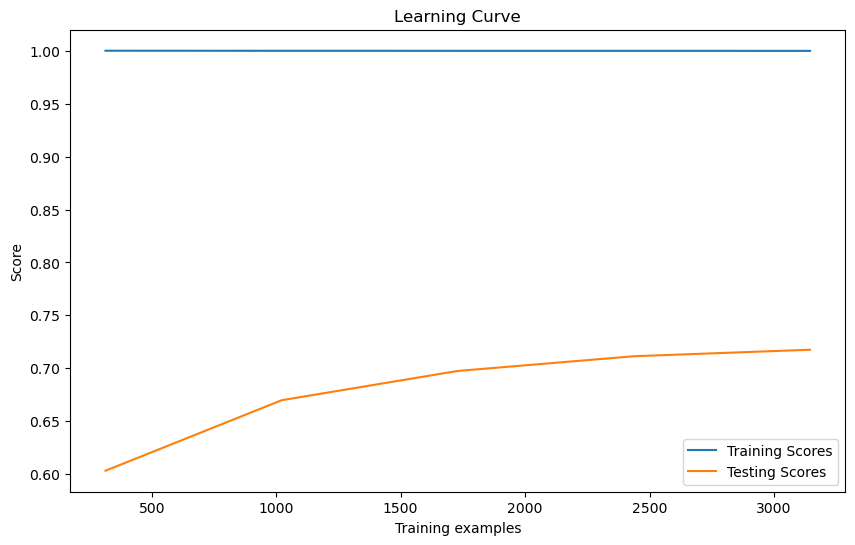

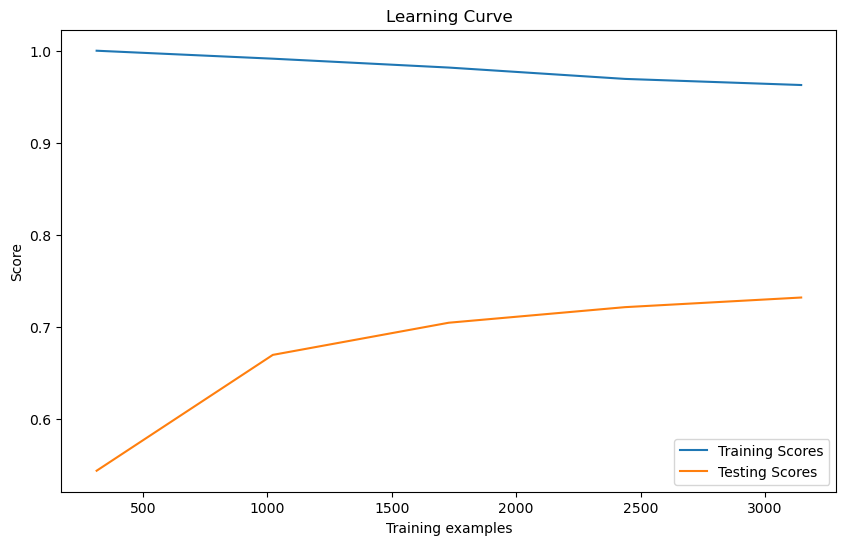

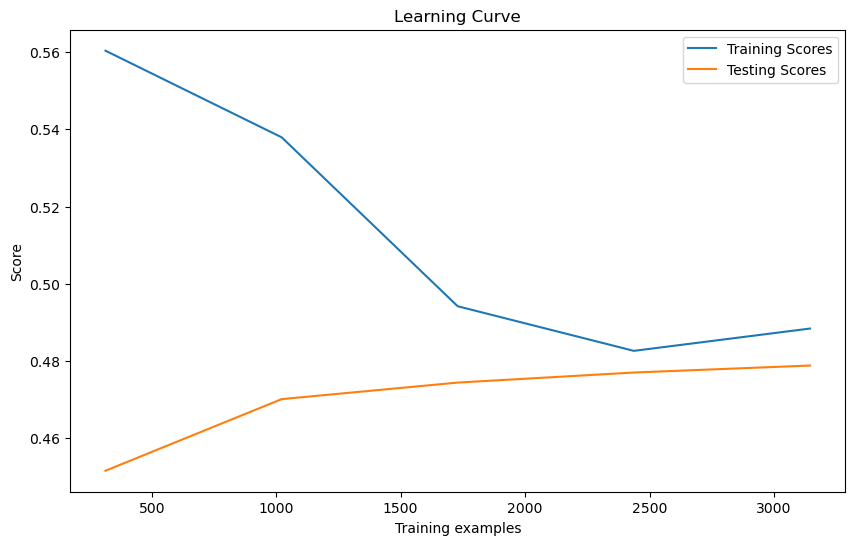

In [91]:
#Plot the learning curves
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=None, train_sizes = np.linspace(0.1, 1.0, 5), scoring='r2'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_scores_mean, label='Training Scores')
    plt.plot(train_sizes, test_scores_mean, label='Testing Scores')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(False)
    plt.show

    

#call the learning curve function for each model
for model_name, best_model in best_models.items():
    print(f'Learning CUrve for {model_name}')
    plot_learning_curve(best_model, X_train, y_train)